# [Insert Creative Title HERE]

## Introduction and Motivation

## Required Libraries

Intro to Pandas:
https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html

Learning the Spotify API through spotipy:
https://spotipy.readthedocs.io/en/latest/#


In [9]:
import sys
import math
import pandas as pd
import spotipy
import spotipy.util as util
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster

## Data Collection and Tidying
//TODO Talk about general authentication flow. 
<br>
//TODO Link example resource. 
<br>
//TODO Explain how to get the spotify username

In [2]:
# Generate authorization token for reading user library
username = '12124976904'

scope = 'user-library-read'
client_id = '076ff5215a374d2481d0117877d79b74'
client_secret = '0ff2fd29106e4b7ebd7da4152d4a20c3'
redirect_uri = 'https://www.google.com/'

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)

else:
    print("Can't get token for", username)
    sys.exit()

//TODO explain the code flow
<br>
//TODO talk about how we chose what columns to keep.
<br>
//TODO Talk about how data is relatively simple and no need to reorganize

In [3]:
def get_saved_tracks():
    results = sp.current_user_saved_tracks()
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

print('Loading Saved Tracks Now. Please be patient!')

tracks = get_saved_tracks()
features = []
track_info = []
for track in tracks:
    features.extend(sp.audio_features(track['track']['uri']))
    track_info.append([track['track']['name'], track['track']['artists'][0]['name']])

features = pd.DataFrame.from_records(features)
track_info = pd.DataFrame.from_records(track_info)
track_info = track_info.rename(columns={0: "title", 1: "artist"})
features = pd.concat([track_info,features],axis=1)
features = features[['title','artist','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'tempo', 'valence']]

features

Loading Saved Tracks Now. Please be patient!
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


,title,artist,acousticness,danceability,energy,instrumentalness,liveness,tempo,valence
0,All the Little Lights,Passenger,0.880000,0.324,0.428,0.000013,0.1070,173.464,0.243
1,Songbird,Aer,0.017500,0.810,0.731,0.000141,0.0655,143.969,0.622
2,Raging Fire,Phillip Phillips,0.011600,0.562,0.850,0.000000,0.1560,125.808,0.410
3,Am I Wrong,Nico & Vinz,0.162000,0.725,0.680,0.000002,0.1580,119.939,0.760
4,Ready To Rock,Oddisee,0.001460,0.593,0.749,0.000069,0.3240,155.958,0.285
...,...,...,...,...,...,...,...,...,...
422,Young Blood,The Naked And Famous,0.000056,0.579,0.865,0.000221,0.6490,104.990,0.358
423,May I Have This Dance,Francis and the Lights,0.469000,0.576,0.451,0.038900,0.0876,90.439,0.803
424,Homecoming - (Explicit),Kanye West,0.360000,0.671,0.740,0.000000,0.1180,86.932,0.908
425,HARD LOVE (feat. Andra Day),NEEDTOBREATHE,0.150000,0.424,0.875,0.000000,0.2700,168.058,0.440


In [4]:
features = pd.read_csv('sample_data') 

## Exploratory Data Analysis & Visualizations

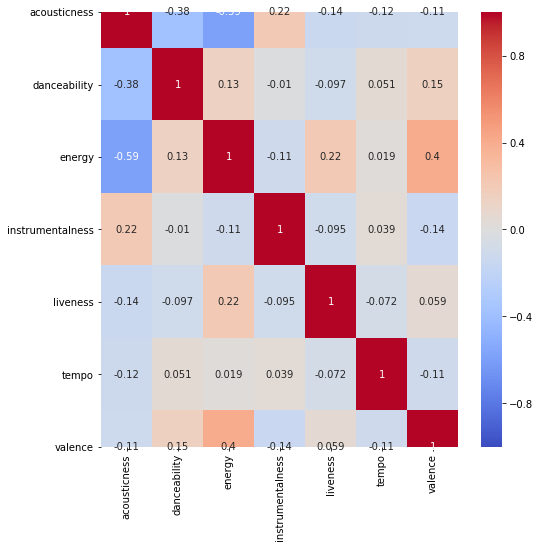

In [17]:
# Explain the columns and how values are determined.
# Summary Statistics
# Histograms
# Correlation Graphs
features.describe()

# corrMatrix = features.corr()
# sns.heatmap(corrMatrix, annot=True)

plt.figure(figsize=(8,8))
sns.heatmap(features.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);


## Machine Learning

In [6]:
# Found cool article on PCA & One Class SVM here:
# https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3
# Implementation is found here:
# http://www.esparsons.com/blogmain/2018/11/27/an-eclectic-spotify-library-visualized-with-chartify

#TODO PCA Analysis
#TODO One Class SVM
#TODO Clustering

#TODO Error analysis...
#TODO Check if new playlists can fit into the SVM
clusters = 

## Takeaways 

In [16]:
df = features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'tempo', 'valence']]

clusters = cluster.AffinityPropagation(preference=-75).fit(df.values)
clusters = clusters.cluster_centers_
len(clusters)

24